Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.proba_map import norm, normalized, import_and_calibrate_mlab_image, preprocess_spectral_image
from src.proba_map import extract_random_sample, data_in_polyhedron, class_polyhedra_GMM_SVM, get_extrema_val, uniformize_data_on_references
from src.proba_map import distance_to_polyhedra, add_negative_distance, softmax_probability_map

Load the Samson dataset

In [2]:
image_path = "./samson/samson.mat"
label_path = "./samson/ground_truth.mat"

image = import_and_calibrate_mlab_image(image_path, image_key='V')
image = image.T.reshape(int(np.round(np.sqrt(image.shape[-1]))), int(np.round(np.sqrt(image.shape[-1]))), image.shape[0]).swapaxes(0,1)

label = import_and_calibrate_mlab_image(label_path, image_key='A')
label = label.T.reshape(int(np.round(np.sqrt(label.shape[-1]))), int(np.round(np.sqrt(label.shape[-1]))), label.shape[0]).swapaxes(0,1)

label_spectra = import_and_calibrate_mlab_image(label_path, image_key='M')
label_spectra = label_spectra.T

Show the Samason dataset

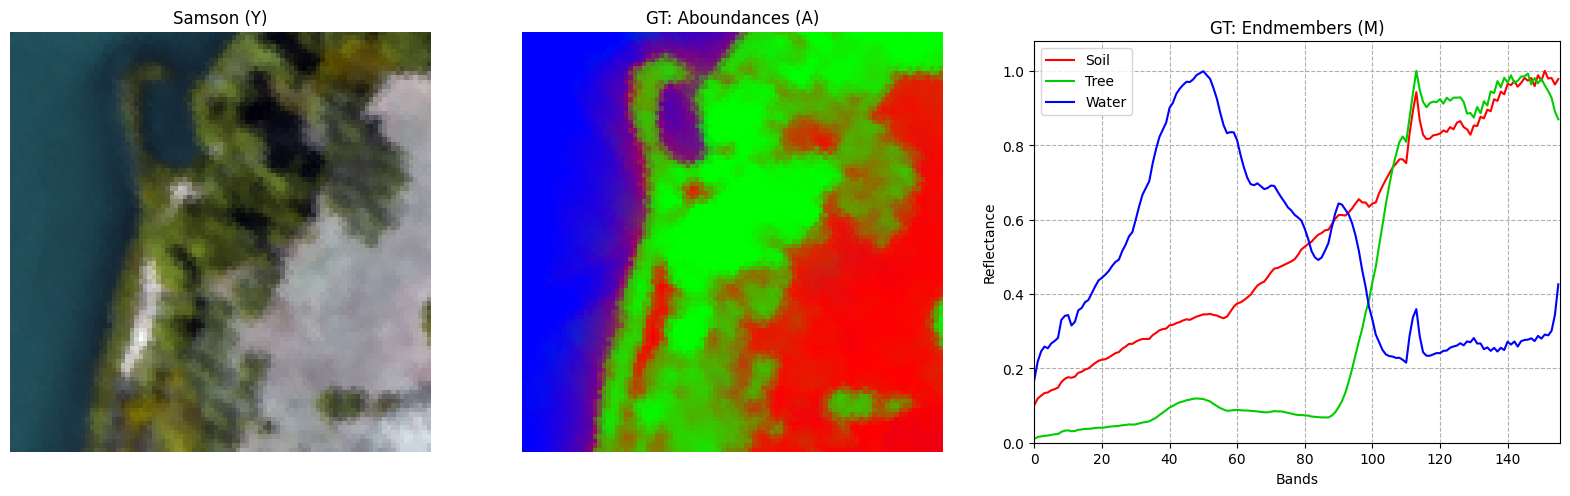

Image size: (95, 95) 
Bands: 156


In [3]:
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [80, 80, 100]}, figsize=(20,6))

ax[0].imshow(normalized(np.transpose((
    normalized(  0.6 * normalized(image[:,:,98]) + 0.2 * normalized(image[:,:,90]) + 0.7 * normalized(image[:,:,50])), 
    normalized(  0.1 * normalized(image[:,:,98]) - 0.3 * normalized(image[:,:,90]) + 0.8 * normalized(image[:,:,50])), 
    normalized(- 0.5 * normalized(image[:,:,98]) + 0.4 * normalized(image[:,:,90]) + 0.9 * normalized(image[:,:,50]))
), axes=(1,2,0))))
ax[0].set_axis_off()
ax[0].set_title("Samson (Y)")

ax[1].imshow(normalized(label))
ax[1].set_axis_off()
ax[1].set_title("GT: Aboundances (A)")

X = np.arange(label_spectra.shape[1])
for i in range(label_spectra.shape[0]):
    ax[2].plot(X, label_spectra[i], c=(int(i==0), 0.8*int(i==1), int(i==2)), label = "Soil" * int(i==0) + "Tree" * int(i==1) + "Water" * int(i==2))
ax[2].legend()
ax[2].set_xlim(-0.1,155.5)
ax[2].set_ylim(0,1.08)
ax[2].set_ylabel("Reflectance")
ax[2].set_xlabel("Bands")
ax[2].grid(linestyle="--")
ax[2].set_aspect(110)
ax[2].set_title("GT: Endmembers (M)")

plt.show()

print("Image size:",image.shape[:-1],"\nBands:",image.shape[-1])

Pre-process the observations Y: homogenize luminance and reduce dimensions with PCA

In [4]:
homogenized_image = preprocess_spectral_image(
    image, 
    homogenize_luminance=1, 
    standardize_channels_beforePCA=False, 
    ndim_PCA_reduction=None, 
    standardize_channels_afterPCA=False, 
    standardize_globally=False
)

homoReduced_image = preprocess_spectral_image(
    homogenized_image, 
    homogenize_luminance=False, 
    standardize_channels_beforePCA=False, 
    ndim_PCA_reduction=12, 
    standardize_channels_afterPCA=False, 
    standardize_globally=False
)

homogenized_data = homogenized_image.reshape(np.prod(homogenized_image.shape[:-1]), homogenized_image.shape[-1])
homoReduced_data = homoReduced_image.reshape(np.prod(homoReduced_image.shape[:-1]), homoReduced_image.shape[-1])

Segment space into polyhedral partitions, using here a GMM (to labellize the data) then a SVM (to compute seperation hyperplanes)

In [5]:
n_classes = 3

In [6]:
sample_prop = 0.2
init = np.asarray([homoReduced_image[-1,-1], homoReduced_image[45,41], homoReduced_image[0,0]]) #n_classes
n_init = 10

homoReduced_sample = extract_random_sample(homoReduced_data, prop=sample_prop)
h = class_polyhedra_GMM_SVM(data=homoReduced_sample, init=init, n_init=n_init, remove_unnecessary_couples=True)

Fitting GMM model on data...
Predicting data on GMM model...
Computing SVM parameters...
Computing minimum H-descriptions...
Done!


Show segmentation results

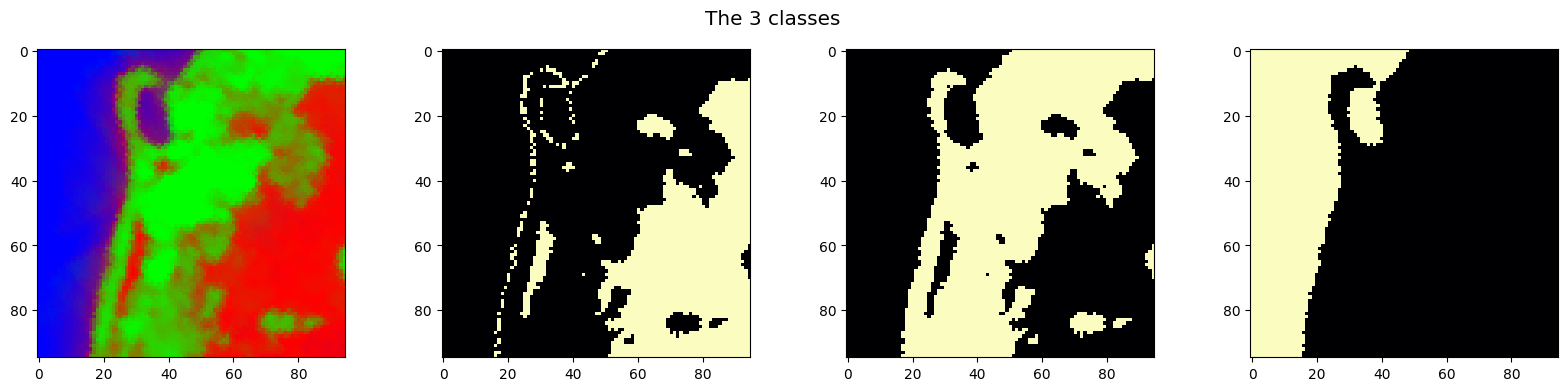

In [7]:
fig, ax = plt.subplots(1,len(h)+1,figsize=(5*(len(h)+1),4))
ax[0].imshow(label)
for i in range(1,len(h)+1):
    binary_class = data_in_polyhedron(homoReduced_data, h[i-1])
    image_class = np.zeros(shape=image.shape[:-1], dtype=binary_class.dtype)
    image_class[np.ones(shape=image.shape[:-1], dtype=bool)] = binary_class
    ax[i].imshow(image_class, cmap='magma')
fig.suptitle(f"The {len(h)} classes", fontsize="x-large")
plt.show()

#### **1st method:** estimation of a real abundance map  =>  from Y only, we determine endmembers M by taking the spectrum with the lowest distance in each polyhedral class, then deduce the abundances A with A = M^{-1} Y

In [8]:
# Extrema extraction (take furthest points, regarding distances to polyhedra)

# computing negative distances to class polyhedra (no need to compute positive parts)
negative_distances = add_negative_distance(homoReduced_data, h)

# extract points (spectra) with the minimum class distance
extrema = get_extrema_val(negative_distances, homogenized_data)

In [9]:
# Linearly transform data
uniformized_data = uniformize_data_on_references(
    data=homogenized_data, 
    references=extrema, 
    orthonormalize_matrix=False, 
    project_in_reference_space=True
)

Data projected in orthonormalized references' space
=> Linear transform


In [10]:
# Turn uniformized data into probability map
to_softmax = False # We will not use softmax function as we directly computed A in Y = M.A

u_proba = None
if to_softmax:
    u_proba = uniformized_data[:,:extrema.shape[0]]
    u_proba = softmax_probability_map(u_proba, multi=1, power=1) # allows to smooth predictions and get a probability map
    u_proba = normalized(u_proba, axis=0) # we suppose that, for each class, there is at least one pixel on the image which has pure class spectrum!
    u_proba = u_proba / np.sum(u_proba, axis=-1, keepdims=True) # the sum must be 1
else:
    u_proba = uniformized_data[:,:extrema.shape[0]].copy()
    u_proba[u_proba<0] = 0 # no data should be negative
    u_proba_sum = u_proba.sum(axis=-1, keepdims=True)
    u_proba_sum_null = u_proba_sum < np.finfo(u_proba.dtype).resolution
    u_proba = u_proba * ~u_proba_sum_null / (u_proba_sum + u_proba_sum_null) # the sum must be 1

In [11]:
u_img = np.zeros(shape=image.shape[:-1]+u_proba.shape[-1:], dtype=u_proba.dtype)
u_img[np.ones(shape=image.shape[:-1], dtype=bool)] = u_proba

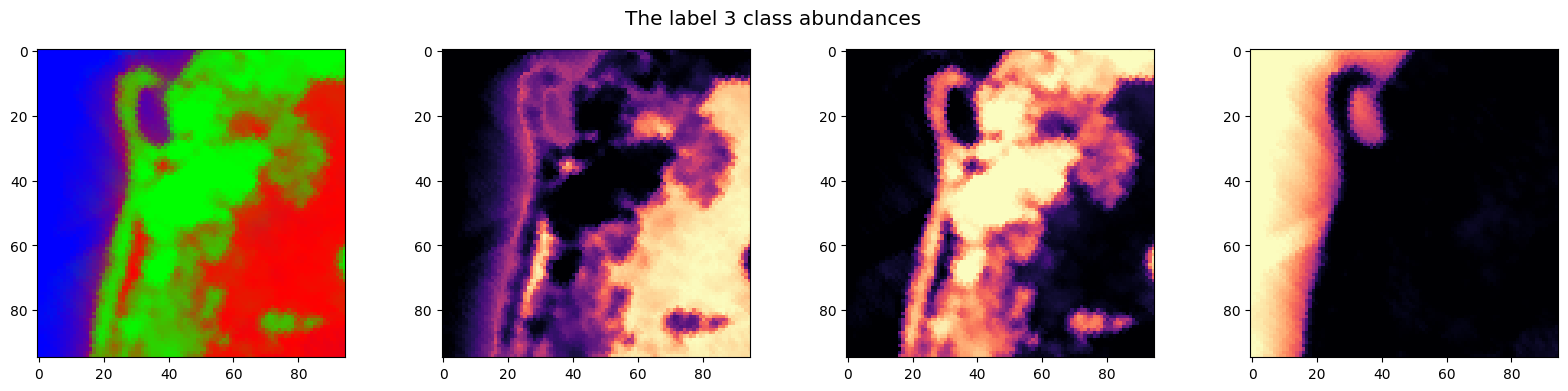

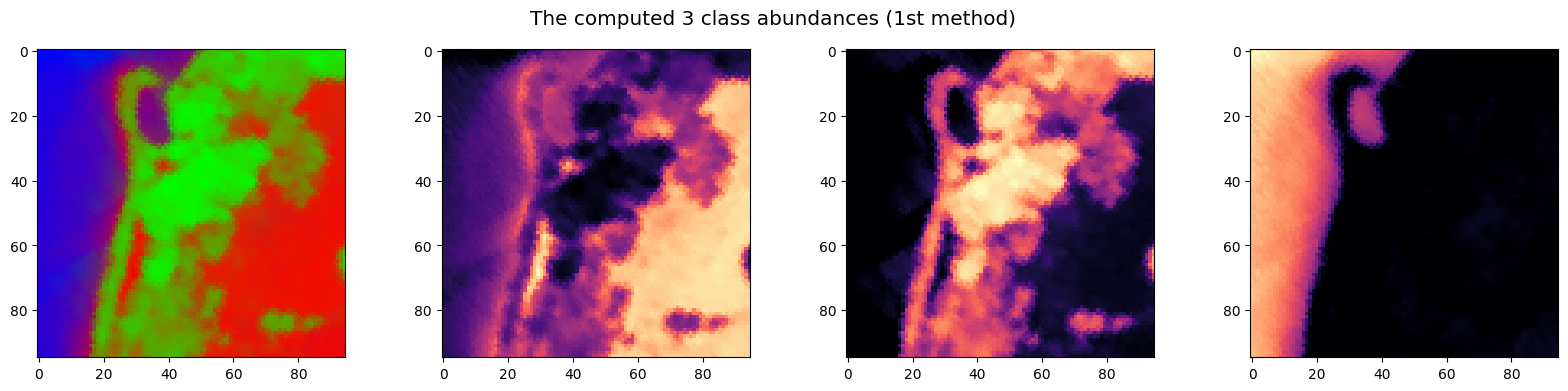

RMSE: 0.14761


In [12]:
fig, ax = plt.subplots(1,label.shape[-1]+1,figsize=(5*(label.shape[-1]+1),4))
ax[0].imshow(label[:,:,:3])
for i in range(label.shape[-1]):
    ax[i+1].imshow(label[:,:,i], cmap='magma')
fig.suptitle(f"The label {label.shape[-1]} class abundances", fontsize="x-large")
plt.show()

fig, ax = plt.subplots(1,u_img.shape[-1]+1,figsize=(5*(u_img.shape[-1]+1),4))
ax[0].imshow(u_img[:,:,:3])
for i in range(u_img.shape[-1]):
    ax[i+1].imshow(u_img[:,:,i], cmap='magma')
fig.suptitle(f"The computed {u_img.shape[-1]} class abundances (1st method)", fontsize="x-large")
plt.show()

print("RMSE:", np.round(np.sqrt(np.mean(np.square(norm(label-u_img)))), decimals=5))

#### **2nd method:** compute probability map (no more real abundances) using directly the distances to polyhedral classes

In [13]:
# Extraction of extreme distances

# compute distances to polyhedra
distances = distance_to_polyhedra(homoReduced_data, h, infos=True)
distances = add_negative_distance(homoReduced_data, h, distances )

# extract the extreme class distances
dis_extrema = get_extrema_val(distances, distances)

Processing class: 1 / 3
Processing class: 2 / 3
Estimated computation time: 2.7 seconds
Processing class: 3 / 3
Done!


In [14]:
# Linearly transform distances
uniformized_distances = uniformize_data_on_references(
    data=distances, 
    references=dis_extrema, 
    orthonormalize_matrix=False, 
    project_in_reference_space=True
)

Data projected in orthonormalized references' space
=> Linear transform


In [15]:
# Turn uniformized data into probability map
to_softmax = True # We will use softmax function as we are working on distances

n_proba = None
if to_softmax:
    n_proba = uniformized_distances[:,:dis_extrema.shape[0]]
    n_proba = softmax_probability_map(n_proba, multi=1, power=1) # allows to smooth predictions and get a probability map
    n_proba = normalized(n_proba, axis=0) # we suppose that, for each class, there is at least one pixel on the image which has pure class spectrum!
    n_proba = n_proba / np.sum(n_proba, axis=-1, keepdims=True) # the sum must be 1
else:
    n_proba = uniformized_distances[:,:dis_extrema.shape[0]].copy()
    n_proba[n_proba<0] = 0 # no data should be negative
    n_proba_sum = n_proba.sum(axis=-1, keepdims=True)
    n_proba_sum_null = n_proba_sum < np.finfo(n_proba.dtype).resolution
    n_proba = n_proba * ~n_proba_sum_null / (n_proba_sum + n_proba_sum_null) # the sum must be 1

In [16]:
n_img = np.zeros(shape=image.shape[:-1]+n_proba.shape[-1:], dtype=n_proba.dtype)
n_img[np.ones(shape=image.shape[:-1], dtype=bool)] = n_proba

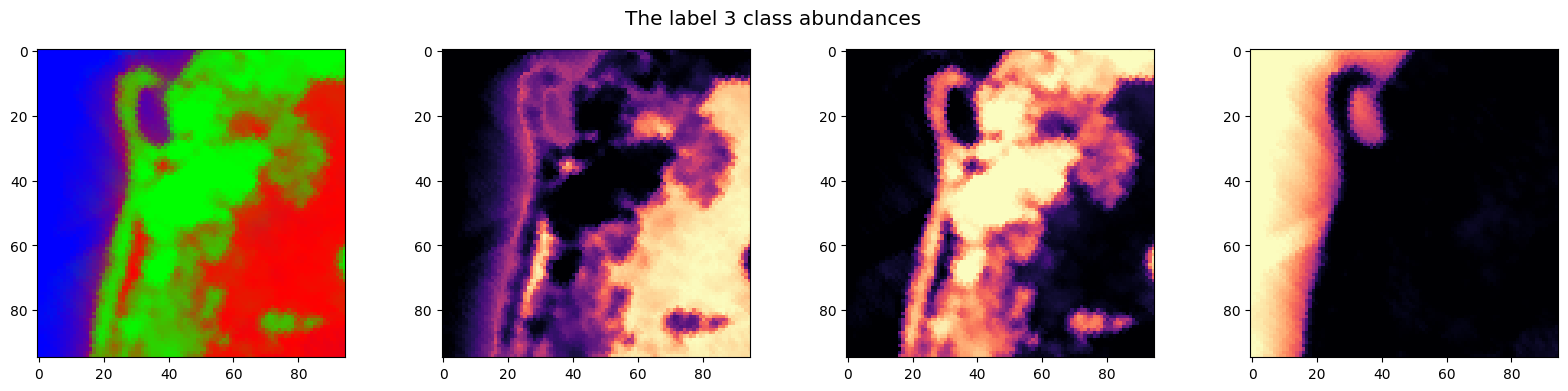

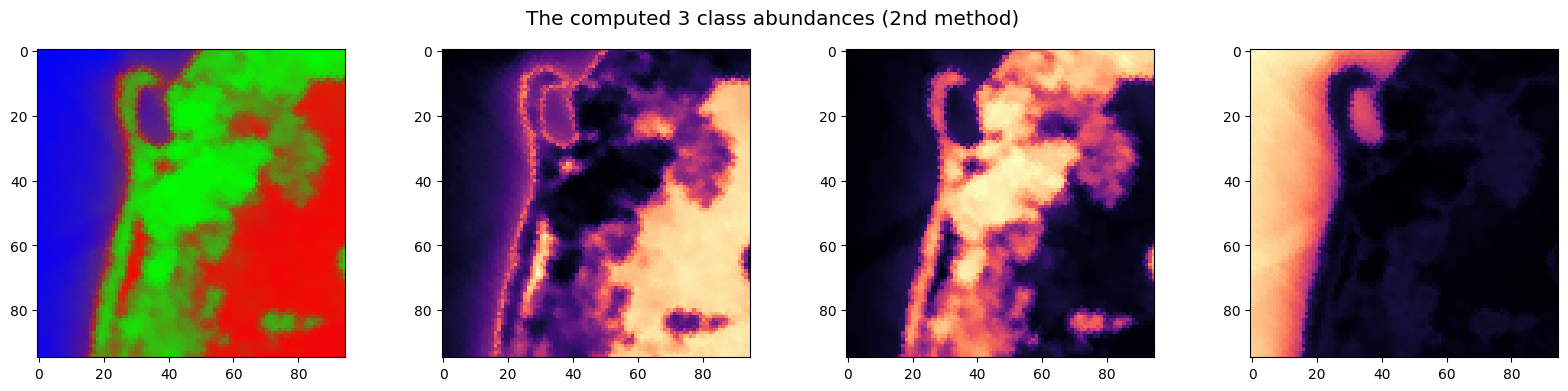

RMSE: 0.09951


In [17]:
fig, ax = plt.subplots(1,label.shape[-1]+1,figsize=(5*(label.shape[-1]+1),4))
ax[0].imshow(label[:,:,:3])
for i in range(label.shape[-1]):
    ax[i+1].imshow(label[:,:,i], cmap='magma')
fig.suptitle(f"The label {label.shape[-1]} class abundances", fontsize="x-large")
plt.show()

fig, ax = plt.subplots(1,n_img.shape[-1]+1,figsize=(5*(n_img.shape[-1]+1),4))
ax[0].imshow(n_img[:,:,:3])
for i in range(n_img.shape[-1]):
    ax[i+1].imshow(n_img[:,:,i], cmap='magma')
fig.suptitle(f"The computed {n_img.shape[-1]} class abundances (2nd method)", fontsize="x-large")
plt.show()

print("RMSE:", np.round(np.sqrt(np.mean(np.square(norm(label-n_img)))), decimals=5))

##### Explaination

* The 1st approach is more linear mixture-friendly, i.e. where, if the (3) pure class spectra can be computed/found (but this is a strong assumption), each pixel is a mix (linear combination) of these pure spectra (i.e.: s = a * s1 + b * s2 + c * s3 ,  with a,b,c scalars between 0 and 1, with their sum equal to 1 ; i.e.: Y = M.A, with Y the observed/captured image pixel[s], M the matrix of the pure class spectra (s1, s2, s3), and A the vector[s] of scalar coefficients (a,b,c) of the corresponding pixel[s])

* The 2nd approach is more compatible with the notion of a (naïve) probability map: in a 3-class problem, it gives more weight to the third class when it is less sure between the two first classes (see last column: water class has higher values where trees and soil are mixed, so where it is less sure to be either water or soil (i.e. where the distances to tree and soil classes get more similar (i.e. boother getting closer to 0), with constant distance to water class))

##### Remark

With these approaches, we have to make the assumption that the pure spectra can be (or tend to be) found in the extrema of the classes' data (i.e., for each class, the pure spectra will be taken from the pixel which has the biggest distance to the other classes' polyhedra (i.e. the smallest distance in its own class' polyhedron)), with the classes (and their frontiers / polyhedra) being determined by the chosen classification method (here, GMM then SVM, which seems to work well). But this assumption here can be wrong (it may be a pixel/point not so extremely far from the distributions), and the computed extrema pixels (which must represent / be close to the label pure spectra) highly depend on the classification chosen (which determines the frontier hyperplanes, and so the polyhedra, and so the list of distances to polyhedra for all pixels) and on the post-processing applied to the image.

The first approach is extremely sensitive to the 'extrema' points determined, as we change the space using a base-changing linear transform based on these extrema. The resulting abundance map may thus change very fast. Thus, determining good spectra (which are close to the label-spectra) is crucial. On the other hand, the second method is more robust, as it is based on distances only, and not on spectra.

#### On prediction errors (abundance map)...

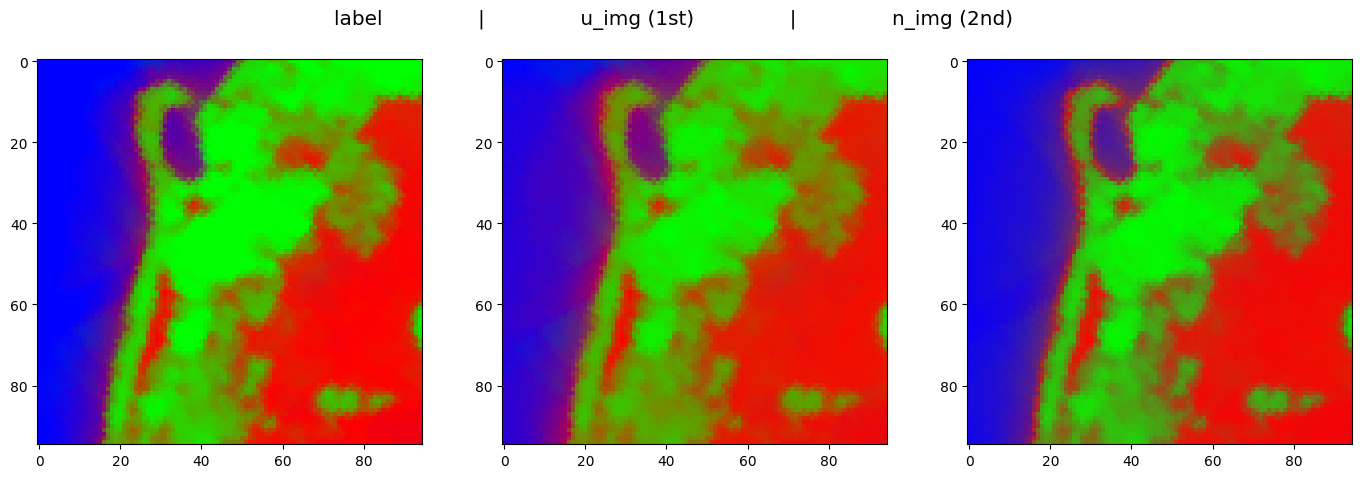

In [18]:
channel = 3

fig, ax = plt.subplots(1,3,figsize=(17,5))
if channel < 0 or channel >= u_img.shape[-1]:
    ax[0].imshow(label)
    ax[1].imshow(u_img)
    ax[2].imshow(n_img)
else:
    ax[0].imshow(label[:,:,channel])
    ax[1].imshow(u_img[:,:,channel])
    ax[2].imshow(n_img[:,:,channel])
fig.suptitle("label               |               u_img (1st)               |               n_img (2nd)", fontsize="x-large")
plt.show()

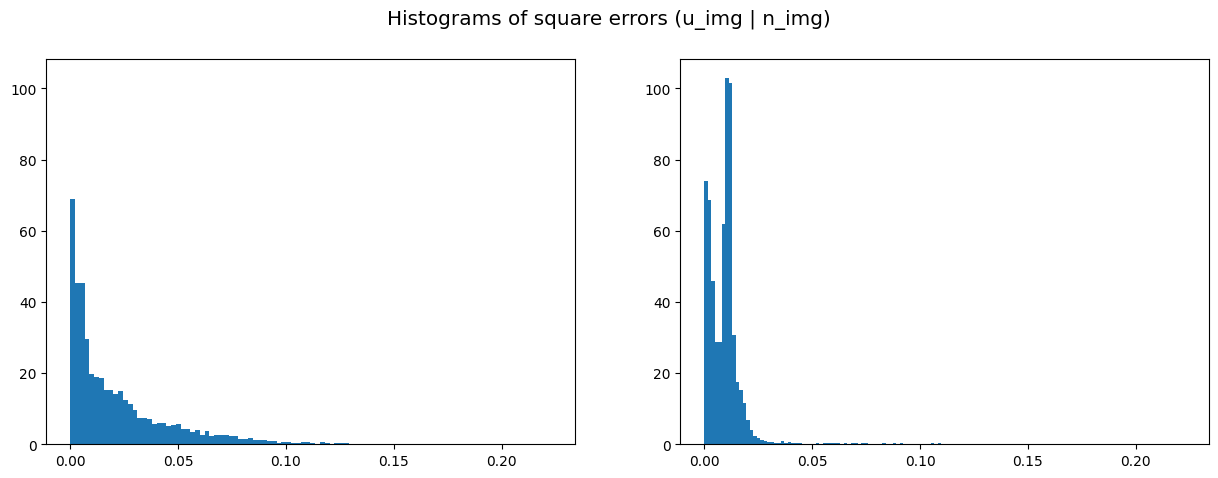

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].hist(np.square(norm(label-n_img)).flatten(), density=True, bins=100, color=(1,1,1))
ax[0].hist(np.square(norm(label-u_img)).flatten(), density=True, bins=100)
ax[1].hist(np.square(norm(label-u_img)).flatten(), density=True, bins=100, color=(1,1,1))
ax[1].hist(np.square(norm(label-n_img)).flatten(), density=True, bins=100)
fig.suptitle("Histograms of square errors (u_img | n_img)", fontsize="x-large")
plt.show()

In [20]:
print("Statistics on Squared Errors (u_img | n_img):")
print("RMSE:", *np.round([np.sqrt(np.mean(np.square(norm(label-u_img)))), np.sqrt(np.mean(np.square(norm(label-n_img))))], decimals=5))
print("STD :", *np.round([np.std (np.square(norm(label-u_img))), np.std (np.square(norm(label-n_img)))], decimals=5))
print("MIN :", *np.round([np.min (np.square(norm(label-u_img))), np.min (np.square(norm(label-n_img)))], decimals=5))
print("MAX :", *np.round([np.max (np.square(norm(label-u_img))), np.max (np.square(norm(label-n_img)))], decimals=5))

Statistics on Squared Errors (u_img | n_img):
RMSE: 0.14761 0.09951
STD : 0.02426 0.01117
MIN : 0.0 0.0
MAX : 0.22254 0.16164


#### On prediction errors (endmembers)...

In [21]:
homoLabel_spectra = preprocess_spectral_image(
    label_spectra, 
    homogenize_luminance=1, 
    standardize_channels_beforePCA=False, 
    ndim_PCA_reduction=None, 
    standardize_channels_afterPCA=False, 
    standardize_globally=False
)

In [22]:
computed_spectra = get_extrema_val(negative_distances, homogenized_data) # = endmembers

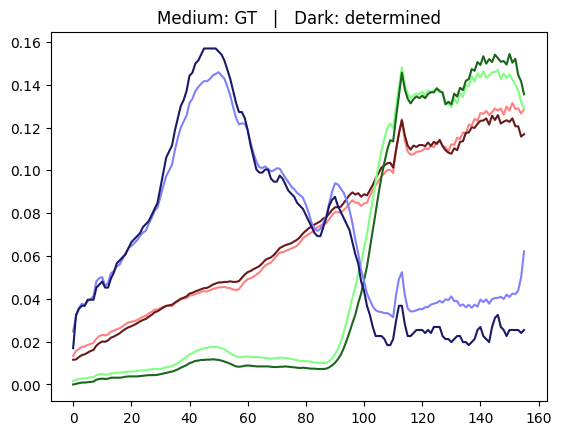

SUM OF SQUARED ERRORS (RGB): 0.00163 0.00508 0.01698


In [23]:
X = np.arange(homoLabel_spectra.shape[-1])
plt.plot(X, homoLabel_spectra[0], c=(1.0,0.5,0.5))
plt.plot(X, computed_spectra[0], c=(0.4,0.1,0.1))
plt.plot(X, homoLabel_spectra[1], c=(0.5,1.0,0.5))
plt.plot(X, computed_spectra[1], c=(0.1,0.4,0.1))
plt.plot(X, homoLabel_spectra[2], c=(0.5,0.5,1.0))
plt.plot(X, computed_spectra[2], c=(0.1,0.1,0.4))
plt.title("Medium: GT   |   Dark: determined")
plt.show()

print("SUM OF SQUARED ERRORS (RGB):", *np.round(np.sum(np.square(computed_spectra - homoLabel_spectra), axis=-1), decimals=5))

Computing the best possible endmembers, i.e. the ones in the observations (Y) which are the closest to the ground-truth!

In [24]:
# compute derivatives of spectra (all the k ones, for k in [0,deepness])!
def add_diff(spectra:np.ndarray, deepness:int=3, flatten:bool=False) -> np.ndarray:
    """
    * spectra: (n_spectra, ndim)
    * deepness: int
    """
    new_spectra = spectra[:, np.newaxis]
    for _ in range(deepness):
        state = new_spectra[:, -1]
        diff_ = state[:, 1:] - state[:, :-1]
        diffn = np.empty(shape=(diff_.shape[0], diff_.shape[-1]+1), dtype=diff_.dtype)
        diffn[:, 0] = diff_[:, 0]
        diffn[:,-1] = diff_[:,-1]
        diffn[:, 1:-1] = (diff_[:, 1:] + diff_[:, :-1]) / 2
        diffn = diffn[:, np.newaxis]
        new_spectra = np.append(new_spectra, diffn, axis=1)
    if flatten:
        new_spectra = new_spectra.reshape(new_spectra.shape[0], int(np.prod(new_spectra.shape[1:])))
    return new_spectra

In [25]:
diff_deppness = 3
ext_homoLabel_spectra = add_diff(homoLabel_spectra, deepness=diff_deppness, flatten=True)
ext_computed_spectra  = add_diff(computed_spectra , deepness=diff_deppness, flatten=True)
ext_homoData_spectra  = add_diff(homogenized_data , deepness=diff_deppness, flatten=True)

In [26]:
best_possible_specArg = np.argmin(norm(ext_homoData_spectra[:, np.newaxis] - ext_homoLabel_spectra), axis=0)
best_possible_spectra = homogenized_data[best_possible_specArg] # best possible spectra

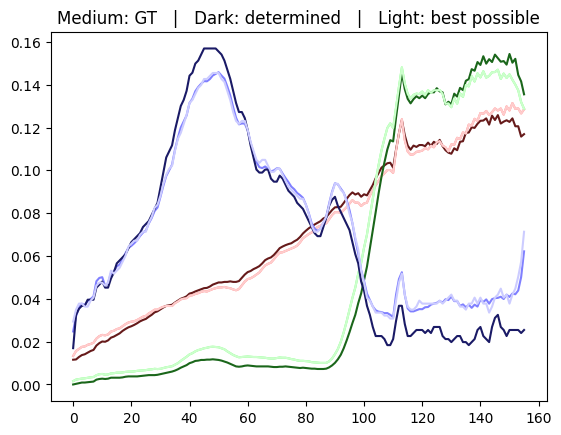

SUM OF SQUARED ERRORS (RGB): 0.00163 0.00508 0.01698


In [27]:
X = np.arange(homoLabel_spectra.shape[-1])
plt.plot(X, homoLabel_spectra[0], c=(1.0,0.5,0.5))
plt.plot(X, computed_spectra[0], c=(0.4,0.1,0.1))
plt.plot(X, best_possible_spectra[0], c=(1.0,0.8,0.8))
plt.plot(X, homoLabel_spectra[1], c=(0.5,1.0,0.5))
plt.plot(X, computed_spectra[1], c=(0.1,0.4,0.1))
plt.plot(X, best_possible_spectra[1], c=(0.8,1.0,0.8))
plt.plot(X, homoLabel_spectra[2], c=(0.5,0.5,1.0))
plt.plot(X, computed_spectra[2], c=(0.1,0.1,0.4))
plt.plot(X, best_possible_spectra[2], c=(0.8,0.8,1.0))
plt.title("Medium: GT   |   Dark: determined   |   Light: best possible")
plt.show()

print("SUM OF SQUARED ERRORS (RGB):", *np.round(np.sum(np.square(computed_spectra - homoLabel_spectra), axis=-1), decimals=5))

##### Remark

In [28]:
distance_green_blue_DETERMINED = norm(computed_spectra[1] - computed_spectra[2])
distance_green_blue_LABELLED = norm(homoLabel_spectra[1] - homoLabel_spectra[2])
print("Distance green-blue spectra [determined]:", np.round(distance_green_blue_DETERMINED, decimals=5))
print("Distance green-blue spectra [labelled]:", np.round(distance_green_blue_LABELLED, decimals=5))

Distance green-blue spectra [determined]: 1.21513
Distance green-blue spectra [labelled]: 1.09011


The determined endmembers (dark) seem to be too far to each other, commpared to what they should be (medium)!

Indeed, we see in the figure above that the determined blue curve/spectrum (dark) is higher on the high parts (left) and lower on the low parts (right) than the ground-truth blue spectrum (medium), and same for the green spectrum. Therefore, the determined (dark) blue and green endmembers are further to each other, than the ground-truth (medium) blue and green ones are. 
We can actually even compute these distances (see above), and the 'green-blue' distance in the determined endmembers is bigger (~1.21) than the one in the labelled endmembers (~1.09).

Thus, the ground-truth endmembers are not exactly the extreme spectra (extrema) of their own classes (i.e. other spectra in the observations Y are "further" than the ground-truth endmembers, which is not supposed to be if we indeed have the equation Y=MA, as Y should be in the simplex formed by the 3 ground-truth endmembers!). Anyways, our approach actually gives pretty good results in terms of abundances! :)